# Singular Spectrum Analysis for Time Series in Python

По материалам:

https://www.gistatgroup.com/gus/ssa_an.pdf 

https://naukovedenie.ru/PDF/41TVN315.pdf

https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition

https://github.com/aj-cloete/pssa

##Импортируем основную библиотеку, а также pandas и numpy 

In [1]:
from mySSA import mySSA

import pandas as pd
import numpy as np

Читаем файл с рядом


In [2]:
ts = pd.read_csv('mean-monthly-air-temperature-deg.csv', parse_dates=True, index_col='Month')

Сосздаем объект для проведения SSA анализа использую полученый ряд

In [3]:
ssa = mySSA(ts)

Основные методы объекта:

In [4]:
[x for x in dir(ssa) if '__' not in x and x[0]!='_']

['decompose',
 'diagonal_averaging',
 'embed',
 'forecast_recurrent',
 'freq',
 'get_contributions',
 'ts',
 'ts_N',
 'ts_name',
 'ts_v',
 'view_reconstruction',
 'view_s_contributions',
 'view_time_series']

Общая процедура SSA следующая:

1. **Создаем траекторную матрицу** из рядаз векторов лагового окна (длина K). 
2.  **Декомпозируем полученую матрицу** с помощью разложения по сингулярным значениям
3. **Провести Eigentripple Grouping** - процесс идентификации пар собственное значение-собственный вектор как тренд, сезонность и шум.
4. **Восстановить временной ряд** из пар собственное значение-собственный вектор, определенных как трендовый и сезонный. Это делается посредством процесса, называемого диагональным усреднением.

In [5]:
K = 40
suspected_seasonality = 12

In [6]:
ssa.embed(embedding_dimension=40, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  36
Trajectory dimensions	: (36, 205)
Complete dimension	: (36, 205)
Missing dimension     	: (36, 0)


In [7]:
ssa.decompose(verbose=True)

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 36
Dimension of projection space	: 20
Characteristic of projection	: 0.9995


Вклад каждого из сигналов (соответствующий каждому сингулярному значению) можно посмотреть следующим образом:

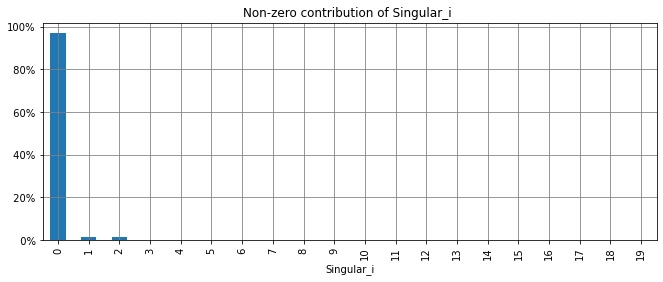

In [8]:
# First enable display of graphs in the notebook
%matplotlib inline 
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 11, 4
rcParams.update({"axes.grid" : True, "grid.color": "gray"})
ssa.view_s_contributions()

Из картинки видно, что большая часть вариации ряда  содержится в первом сигнале (соответствующем первому сингулярному вектору). Масштаб на изображении выше затрудняет понимание того, что происходит с оставшимися сингулярными значениями.


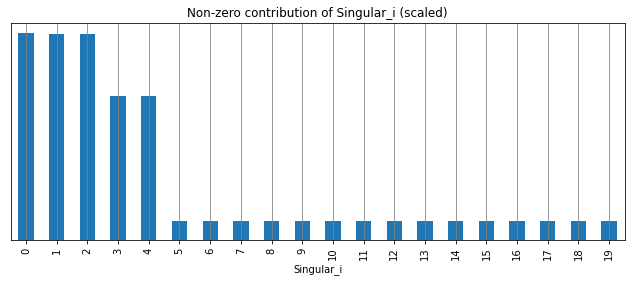

In [9]:
ssa.view_s_contributions(adjust_scale=True)

Переберем этот диапазон и посмотреть на первые 5 элементов. 

Аддитивные элементы сигнала хранятся в словаре object.Xs.

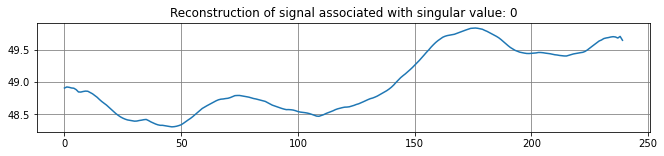

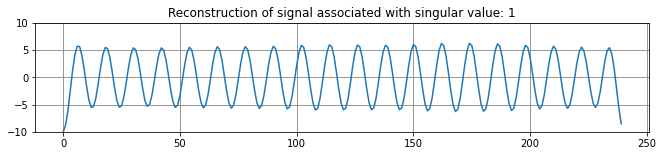

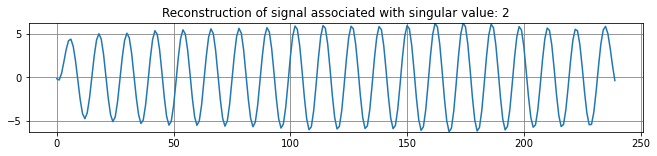

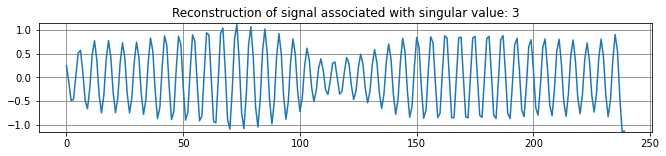

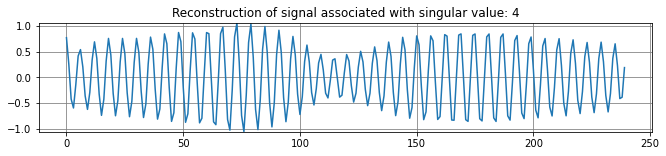

In [10]:
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4


Посмотрим на результат реконструкции сигнала из этих 5 составляющих. Складываем первые 5 сигналов и передаем `object.view_reconstruction`:

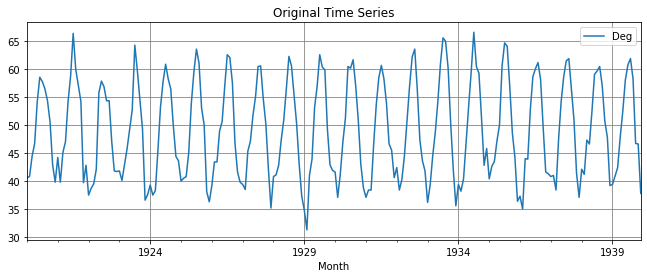

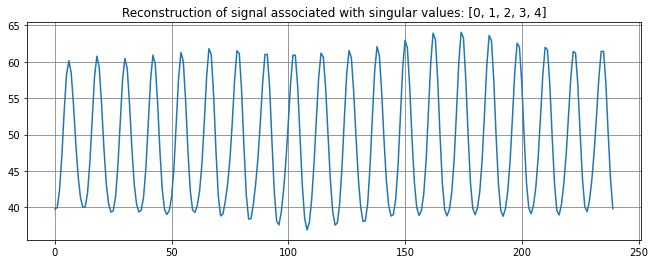

In [11]:
ssa.ts.plot(title='Original Time Series'); # This is the original series for comparison
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)

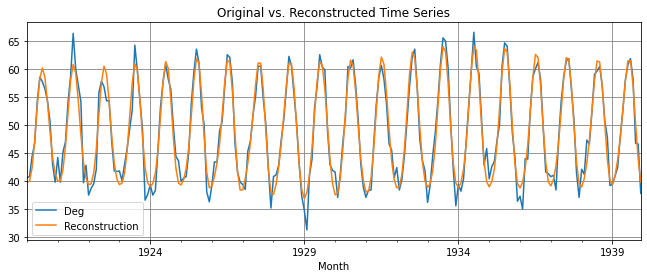

In [12]:
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

Мы можем приблизиться к исходному ряду сильней, добавив дополнительные сигналы от оставшихся сингулярных значений. Используем первые 10 сингулярных значений

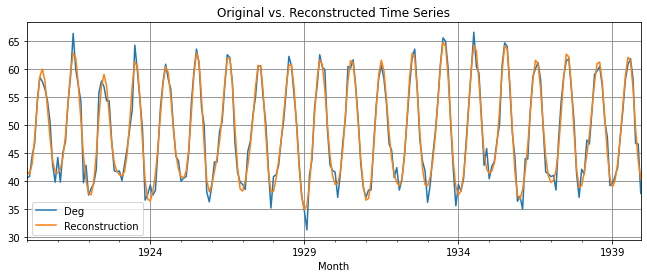

In [13]:
streams10 = [i for i in range(10)]
reconstructed10 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams10], 
                                          names=streams10, return_df=True, plot=False)
ts_copy10 = ssa.ts.copy()
ts_copy10['Reconstruction'] = reconstructed10.Reconstruction.values
ts_copy10.plot(title='Original vs. Reconstructed Time Series');

Для прогноза, используется метод `forecast_recurrent`
Передаем в него часть сингулярных значений. 


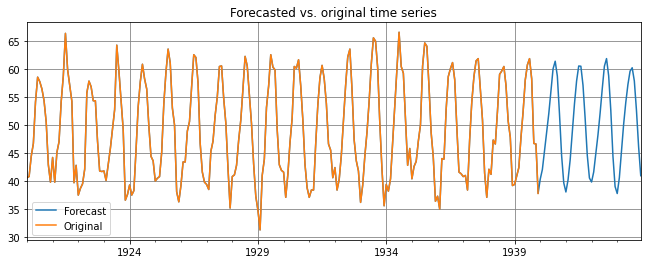

In [14]:
ssa.forecast_recurrent(steps_ahead=48, singular_values=streams10, plot=True)

Прогноз на более длинный промежуток
 

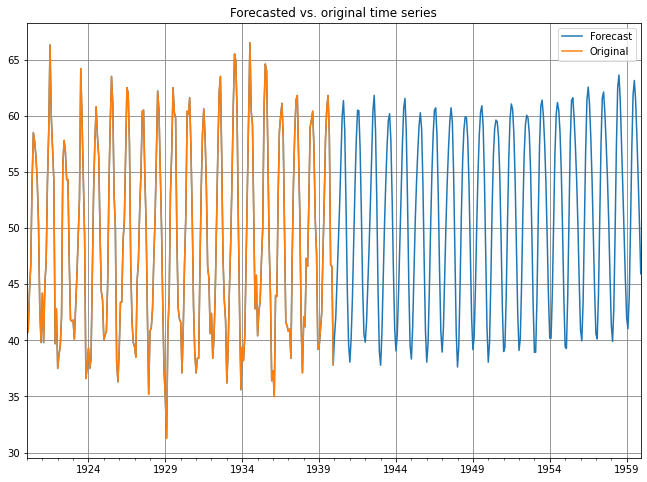

In [15]:
rcParams['figure.figsize'] = 11,8
ssa.forecast_recurrent(steps_ahead=ssa.ts.shape[0], singular_values=streams10, plot=True)
rcParams['figure.figsize'] = 11, 4